In [441]:
%matplotlib notebook
from matplotlib import rcParams
import matplotlib.pyplot as plt

import numpy as np
import numpy.linalg as la

import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.linalg import toeplitz, circulant
from scipy.stats import linregress as linreg

import scipy.fftpack as fft

import sympy as smp

from pytex import *

from scipy.integrate import quadrature as quad

from matplotlib import animation
animation.rcParams['animation.writer'] = 'ffmpeg'
from IPython.display import HTML

import timeit

In [7]:
rcParams.update({'font.size': 12})

In [396]:
np.set_printoptions(precision=10)
np.set_printoptions(suppress=True)

# Parameters

In [428]:
# parameters ************************************************************
m = 2**6 #2**5 #number of cell centers
L = 1    #length of side of square domain
CFL = .5 #max CFL number at which to run

Re = 100

t0, t_final = 0, 5#40

# calcuated parameters **************************************************
h = L/m
k = CFL*h
t_steps = int((t_final-t0)/k)

mux, muy = m+1, m+2
mvx, mvy = m+2, m+1
mpx, mpy = m+2, m+2

# Functions

In [444]:
def setup_grid(m, h):
    grid = {}
    
    # Laplacian for pressure
    
    D2x = 1/h**2 * sp.diags([ [-2]*m, [1]*(m-1), [1]*(m-1) ], offsets=[0,1,-1], format='lil')
    # modify for Neumann BCs
    D2x[ 0, 0] = -D2x[0,1]
    D2x[-1,-1] = -D2x[-1,-2]
    
    Lp = sp.lil_matrix((m**2+1, m**2+1))
    Lp[:-1,:-1] = sp.kron(D2x,sp.eye(m)) + sp.kron(sp.eye(m), D2x)
    # lagrange multiplier
    Lp[-1, :-1] = np.ones(m**2)
    Lp[:-1, -1] = np.ones(m**2).reshape((m**2,1))
    grid['Lp'] = Lp.tocsr()
    
    # Laplacian for diffusion of u
    mx, my = m-1, m
    D2x = 1/h**2 * sp.diags([ [-2]*mx, [1]*(mx-1), [1]*(mx-1) ], offsets=[0,1,-1], format='lil')
    D2y = 1/h**2 * sp.diags([ [-2]*my, [1]*(my-1), [1]*(my-1) ], offsets=[0,1,-1], format='lil')
    # Account for implicit boundary conditions
    D2y[ 0, 0] = -3*D2y[0,1]
    D2y[-1,-1] = -3*D2y[-1,-2]
    
    grid['Lu'] = sp.kron(D2x,sp.eye(my)) + sp.kron(sp.eye(mx), D2y)
    
    # Laplacian for diffusion of u
    mx, my = my, mx
    D2x = 1/h**2 * sp.diags([ [-2]*mx, [1]*(mx-1), [1]*(mx-1) ], offsets=[0,1,-1], format='lil')
    D2y = 1/h**2 * sp.diags([ [-2]*my, [1]*(my-1), [1]*(my-1) ], offsets=[0,1,-1], format='lil')
    # Account for implicit boundary conditions
    D2x[ 0, 0] = -3*D2x[0,1]
    D2x[-1,-1] = -3*D2x[-1,-2]
    
    grid['Lv'] = sp.kron(D2x,sp.eye(my)) + sp.kron(sp.eye(mx), D2y)
    
    return grid

def update_ghost_diffusion(u, v, ps, h, k, explicit=True):
    us = u.copy()
    vs = v.copy()
    
    # update u
    #   vertical
    us[:, 0] = np.zeros(len(us[:, 0]))
    us[:,-1] = np.zeros(len(us[:,-1]))
    #   horizontal
    us[0]  = 2*     k*np.diff(ps[ 1])/h  - explicit*us[ 1]
    us[-1] = 2*(1 + k*np.diff(ps[-2])/h) - explicit*us[-2]
    #   average corners
    us[ 0, 0] /= 2
    us[ 0,-1] /= 2
    us[-1, 0] /= 2
    us[-1,-1] /= 2
    
    # update v
    #   horizontal
    vs[ 0] = np.zeros(len(vs[ 0,:]))
    vs[-1] = np.zeros(len(vs[-1,:]))
    #   vertical
    vs[:, 0] = 2*k*np.diff(ps[:, 1])/h - explicit*vs[:, 1]
    vs[:,-1] = 2*k*np.diff(ps[:,-2])/h - explicit*vs[:,-2]
    #   average corners
    vs[ 0, 0] /= 2
    vs[ 0,-1] /= 2
    vs[-1, 0] /= 2
    vs[-1,-1] /= 2
    
    return us, vs
    
def ave_x(edge):
    return (edge[:,:-1] + edge[:,1:])/2
    
def ave_y(edge):
    return (edge[:-1,:] + edge[1:,:])/2

def ave_c(edge):
    ave = edge[:,:-1] + edge[:,1:]
    return (ave[:-1,:] + ave[1:,:])/4

def up_wind(us, vs, h, k):
    # compute (u,v).grad(u)
    U, V = ave_x(us[1:-1,:]), ave_x(vs[:,1:-1])
    
    pos_id = np.greater(U, 0)
    F = pos_id*us[1:-1,:-1] + np.logical_not(pos_id)*us[1:-1,1:]
    pos_id = np.greater(V, 0)
    G = pos_id*us[:-1,1:-1] + np.logical_not(pos_id)*us[1:,1:-1]
    # get v on vertical edges
    V = ave_c(vs[:,1:-1])
    u_adv = 1/h * (us[1:-1, 1:-1] * np.diff(F,1,1) + V*np.diff(G,1,0))
    
    # compute (u,v).grad(v)
    U, V = ave_y(us[1:-1,:]), ave_y(vs[:,1:-1])
    pos_id = np.greater(U, 0)
    F = pos_id*vs[1:-1,:-1] + np.logical_not(pos_id)*vs[1:-1,1:]
    pos_id = np.greater(V, 0)
    G = pos_id*vs[:-1,1:-1] + np.logical_not(pos_id)*vs[1:,1:-1]
    # get u on horizontal edges
    U = ave_c(us[1:-1,:])
    v_adv = 1/h * (vs[1:-1, 1:-1] * np.diff(G,1,0) + U*np.diff(F,1,1))
    
    return u_adv, v_adv

def laplacian(us, h):
    ret  = -4*us[1:-1, 1:-1]
    ret +=    us[ :-2, 1:-1]
    ret +=    us[1:-1,  :-2]
    ret +=    us[2:  , 1:-1]
    ret +=    us[1:-1, 2:  ]
    return ret/h**2

def advec_diffuse(us, vs, ps, h, k, Re, grid):
    u_adv, v_adv = up_wind(us, vs, h, k)
    u_star, v_star = update_ghost_diffusion(us, vs, ps, h, k, False)
    
    alpha = .5*k/Re
    
    # solve u first
    my, mx = [m-2 for m in us.shape]
    
    I = sp.eye(mx*my)
    # Compute right hand-side (I+L)*u on the grid.
    f = us[1:-1, 1:-1] + alpha*laplacian(us,h) - k*u_adv
    
    # incorporate boundary conditions
    f[0]   += alpha/h**2 * u_star[0   ,1:-1]
    f[-1]  += alpha/h**2 * u_star[-1  ,1:-1]
    f[:,0] += alpha/h**2 * u_star[1:-1, 0  ]
    f[:,-1]+= alpha/h**2 * u_star[1:-1, -1 ]
    f = f.T.flatten() # .flatten() stacks rows by default
    
    u_star[1:-1, 1:-1] = spla.spsolve(I - alpha*grid['Lu'], f).reshape(mx,my).T
    
    # solve v second
    my, mx = [m-2 for m in vs.shape]
    
    I = sp.eye(mx*my)
    # Compute right hand-side (I+L)*u on the grid.
    f = vs[1:-1, 1:-1] + alpha*laplacian(vs,h) - k*v_adv
    
    #print('f')
    #print(f[:,:4])
    
    # incorporate boundary conditions
    f[0]   += alpha/h**2 * v_star[0   ,1:-1]
    f[-1]  += alpha/h**2 * v_star[-1  ,1:-1]
    f[:,0] += alpha/h**2 * v_star[1:-1, 0  ]
    f[:,-1]+= alpha/h**2 * v_star[1:-1, -1 ]
    
    f = f.T.flatten() # flatten stacks rows by default
    
    v_star[1:-1, 1:-1] = spla.spsolve(I - alpha*grid['Lv'], f).reshape(mx,my).T
    
    u_star, v_star = update_ghost_diffusion(u_star, v_star, ps, h, k, True)
    
    return u_star, v_star

def divergence(us, vs, h):
    return ( np.diff(us[1:-1],axis=1) + np.diff(vs[:,1:-1],axis=0) )/h

def pressure(u_star, v_star, h, k, grid):
    div = divergence(u_star, v_star, h)/k
    mx, my = div.shape
    
    rhs = np.zeros(mx*my+1)
    rhs[:-1] = div.T.flatten()
    
    pcr = spla.spsolve(grid['Lp'], rhs)
    
    lagrange_mult = pcr[-1]
    
    ps = np.zeros((mpy, mpx))
    ps[1:-1, 1:-1] = pcr[:-1].reshape((mx, my)).T
    # ensure Neumann BCs
    ps[0] = ps[1]
    ps[-1] = ps[-2]
    ps[:,0] = ps[:,1]
    ps[:,-1] = ps[:,-2]
    
    return ps, lagrange_mult
    
def correct(us, vs, ps, h, k, grid):
    px = np.diff(ps[:,1:-1], axis=1)/h
    us[:,1:-1] -= k*px
    py = np.diff(ps[1:-1], axis=0)/h
    vs[1:-1,:] -= k*py
    
    return us, vs

def navier_stokes(m, L, CFL, Re, t0, t_final):
    h = L/m
    k = CFL*h
    t_steps = int((t_final-t0)/k)

    mux, muy = m+1, m+2
    mvx, mvy = m+2, m+1
    mpx, mpy = m+2, m+2
    
    us = np.zeros((muy, mux))
    vs = np.zeros((mvy, mvx))
    ps = np.zeros((mpy, mpx))
    grid = setup_grid(m, h)
    
    for step in range(t_steps):
        u_star, v_star = advec_diffuse(us, vs, ps, h, k, Re, grid)
        ps, lagrange_mult = pressure(u_star, v_star, h, k, grid)
        us, vs = correct(u_star, v_star, ps, h, k, grid)
    
    return us, vs

# Solve

In [446]:
us = np.zeros((muy, mux))
vs = np.zeros((mvy, mvx))
ps = np.zeros((mpy, mpx))
grid = setup_grid(m, h)

In [447]:
for step in range(t_steps):
    u_star, v_star = advec_diffuse(us, vs, ps, h, k, Re, grid)
    ps, lagrange_mult = pressure(u_star, v_star, h, k, grid)
    us, vs = correct(u_star, v_star, ps, h, k, grid)

In [445]:
%%timeit
m = 2**6 #2**5 #number of cell centers
L = 1    #length of side of square domain
CFL = .5 #max CFL number at which to run
Re = 100
t0, t_final = 0, 5#40

navier_stokes(m, L, CFL, Re, t0, t_final)

1 loop, best of 3: 37.2 s per loop


# Compare to GGS82 and MSA09 data

In [448]:
X_u, Y_u = np.meshgrid(np.linspace(0,L,muy), np.linspace(0,L,mux))

In [452]:
X_u[muy//2]

array([0.          , 0.0153846154, 0.0307692308, 0.0461538462,
       0.0615384615, 0.0769230769, 0.0923076923, 0.1076923077,
       0.1230769231, 0.1384615385, 0.1538461538, 0.1692307692,
       0.1846153846, 0.2         , 0.2153846154, 0.2307692308,
       0.2461538462, 0.2615384615, 0.2769230769, 0.2923076923,
       0.3076923077, 0.3230769231, 0.3384615385, 0.3538461538,
       0.3692307692, 0.3846153846, 0.4         , 0.4153846154,
       0.4307692308, 0.4461538462, 0.4615384615, 0.4769230769,
       0.4923076923, 0.5076923077, 0.5230769231, 0.5384615385,
       0.5538461538, 0.5692307692, 0.5846153846, 0.6         ,
       0.6153846154, 0.6307692308, 0.6461538462, 0.6615384615,
       0.6769230769, 0.6923076923, 0.7076923077, 0.7230769231,
       0.7384615385, 0.7538461538, 0.7692307692, 0.7846153846,
       0.8         , 0.8153846154, 0.8307692308, 0.8461538462,
       0.8615384615, 0.8769230769, 0.8923076923, 0.9076923077,
       0.9230769231, 0.9384615385, 0.9538461538, 0.9692

<IPython.core.display.Javascript object>


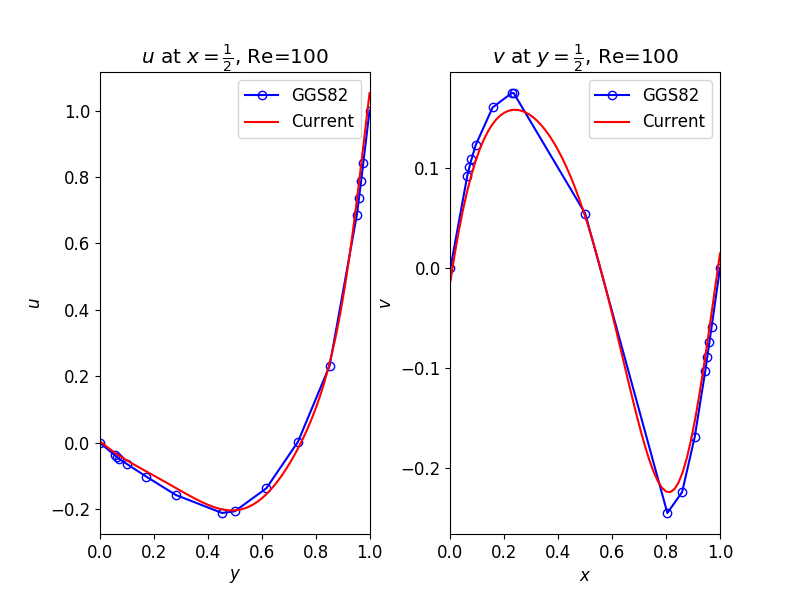

In [466]:
#data locations for u component of velocity
ys_u = [1,0.9766,0.9688,0.9609,0.9531,0.8516,0.7344,0.6172,0.5,0.4531,0.2813,0.1719,0.1016,0.0703,0.0625,0.0547,0]
xs_u = [.5]*len(ys_u)

#data locations for v component of velocity
xs_v = [1,0.9688,0.9609,0.9531,0.9453,0.9063,0.8594,0.8047,
        0.5,0.2344,0.2266,0.1563,0.0938,0.0781,0.0703,0.0625,0]
ys_v = [.5]*len(xs_v)

# Determine the values for comparison to GS82
if Re == 100:
    # Values of u at (xiu,yiu)
    uGGS82 = [1,0.84123,0.78871,0.73722,0.68717,0.23151,
              0.00332,-0.13641,-0.20581,-0.21090,-0.15662,
              -0.10150,-0.06434,-0.04775,-0.04192,-0.03717,0];
    # Values of v at (xiv,yiv)
    vGGS82 = [0,-0.05906,-0.07391,-0.08864,-0.10313,-0.16914,
              -0.22445,-0.24533,0.05454,0.17527,0.17507,0.16077,
              0.12317,0.10890,0.10091,0.09233,0];
elif Re == 1000:
    # Values of u at (xiu,yiu)
    uGGS82 = [1,0.65928,0.57492,0.51117,0.46604,0.33304,0.18719,
              0.05702,-0.06080,-0.10648,-0.27805,-0.38289,-0.29370,
              -0.22220,-0.20196,-0.18109,0];
    # Values of v at (xiv,yiv)
    vGGS82 = [0,-0.21388,-0.27669,-0.33714,-0.39188,-0.51550,
              -0.42665,-0.31966,0.02526,0.32235,0.33075,0.37095,
              0.32627,0.30353,0.29012,0.27485,0];

    

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(8,6))
plt.subplots_adjust(wspace=.3)

ax1.set_xlim((0,1))
ax1.set_title('$u$ at $x=\\frac{1}{2}$, Re=%d' % Re)
ax1.set_xlabel('$y$')
ax1.set_ylabel('$u$')
ax1.plot(ys_u, uGGS82, 'bo-', fillstyle='none', label='GGS82')

ax1.plot(np.linspace(0,L,muy), us[:,muy//2], 'r-', label='Current')

ax1.legend()

ax2.set_xlim((0,1))
ax2.set_title('$v$ at $y=\\frac{1}{2}$, Re=%d' % Re)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$v$')
ax2.plot(xs_v, vGGS82, 'bo-', fillstyle='none', label='GGS82')

ax2.plot(np.linspace(0,L,muy), vs[mux//2], 'r-', label='Current')

ax2.legend()

plt.show()

In [467]:
us[:,:4]

array([[ 0.          , -0.0000289399, -0.0000654929, -0.0000797778],
       [ 0.          ,  0.0000289431,  0.0000655263,  0.0000798433],
       [ 0.          ,  0.0000369179,  0.000061324 ,  0.0000261639],
       [ 0.          ,  0.0000150425, -0.0000201696, -0.0001531451],
       [ 0.          , -0.0000207146, -0.0001421261, -0.0004026993],
       [ 0.          , -0.0000617996, -0.0002829074, -0.0006882062],
       [ 0.          , -0.0001041314, -0.0004305239, -0.0009890876],
       [ 0.          , -0.0001458839, -0.0005786224, -0.0012933944],
       [ 0.          , -0.0001863042, -0.0007239934, -0.0015944344],
       [ 0.          , -0.000225137 , -0.0008651297, -0.0018886315],
       [ 0.          , -0.0002623498, -0.0010014203, -0.0021742039],
       [ 0.          , -0.0002980006, -0.001132703 , -0.0024503622],
       [ 0.          , -0.0003321746, -0.001259017 , -0.0027168287],
       [ 0.          , -0.000364953 , -0.0013804676, -0.0029735497],
       [ 0.          , -0.00039639

In [465]:
muy

66